In [1]:
import numpy as np 
import pandas as pd 
from IPython.display import Image
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import os

In [2]:
# folder_path = "./kaggle/input/ai-vs-human-generated-dateset/"
folder_path = "./scratch"
train_csv = os.path.join(folder_path, "train.csv")
train = pd.read_csv(train_csv)

In [3]:
train.head() 

,Unnamed: 0,file_name,label
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [4]:
# Check missing values in each column
missing_values = train.isnull().sum()
missing_values = missing_values[missing_values > 0]

print(f'There are {len(missing_values)} missing values')

There are 0 missing values


In [5]:
# Check the occurances of label 0 and 1
label_counts=train['label'].value_counts()
print(label_counts)

label
1    39975
0    39975
Name: count, dtype: int64


In [6]:
# Check if all filenames end with ".jpg"
all_jpg = train["file_name"].str.endswith(".jpg").all()

if all_jpg:
    print("All filenames end with .jpg")

All filenames end with .jpg


In [7]:
#rename the file name to include the path and the file name
# train["file_name"] = "/kaggle/input/ai-vs-human-generated-dataset/train_data/" + train["file_name"].str.split("/").str[-1]
train["file_name"] = train["file_name"].apply(lambda x: os.path.join(folder_path, "train_data", os.path.basename(x)))

'label : 1'

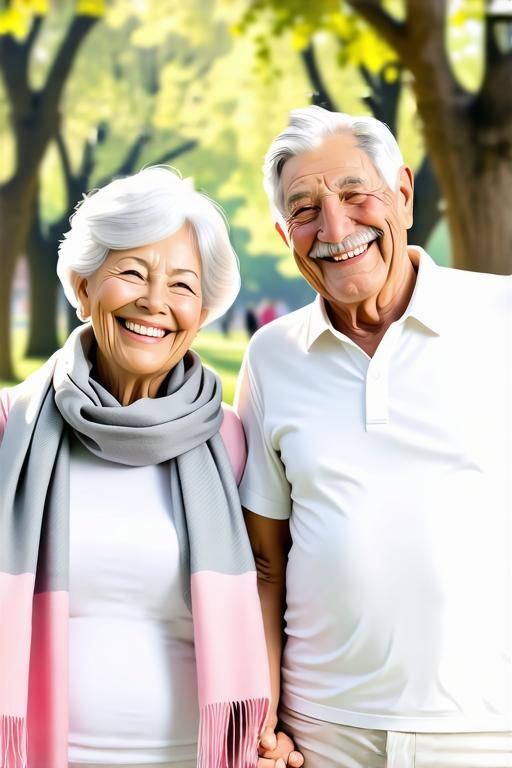

'label : 0'

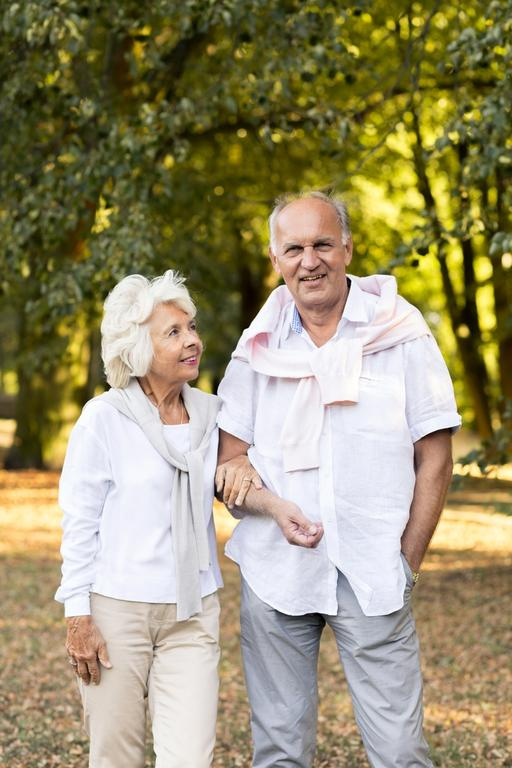

In [8]:
# Check the sample of AI generated images(label1) and Real Images(label0)
file_names = [fname for fname in train["file_name"]]
from IPython.display import Image
display(f'label : {train["label"][0]}')
display(Image(file_names[0]))
display(f'label : {train["label"][1]}')
display(Image(file_names[1]))

In [9]:
# Split into train (80%) and test (20%)
train_df, test_df = train_test_split(train, test_size=0.2, random_state=42, stratify=train['label'])

# Split train into actual train (60%) and validation (20%) 
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['label'])  

# Check dataset sizes
print(f"Train Size: {len(train_df)}")
print(f"Validation Size: {len(val_df)}")
print(f"Test Size: {len(test_df)}")


Train Size: 47970
Validation Size: 15990
Test Size: 15990


In [10]:
# get image size
from PIL import Image
# def get_image_size(file_path):
#     with Image.open(file_path) as img:
#         return img.size  # (width, height)

# # Get sizes for all images
# image_sizes = [get_image_size(fname) for fname in train_df["file_name"]]

# # Convert to DataFrame and show summary
# size_df = pd.DataFrame(image_sizes, columns=["Width", "Height"])
# print(size_df.describe())

In [11]:
# Transformation (Resize + Normalize + Data Augmentation)
transform = transforms.Compose([
    transforms.Resize((112, 320)),  # Resize image into smallest size
    transforms.RandomCrop((100, 300)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_labels=None, transform=None):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        if image_labels == None:
            img_label = -1
        else:
            img_label = self.image_labels[idx]
        try:
            img = Image.open(img_path).convert("RGB")  # Ensure RGB format
            if self.transform:
                img = self.transform(img)  # Resize + Normalize
            return img, img_label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None

In [12]:
# Create Dataset and DataLoader
image_paths = train_df["file_name"].tolist()  
image_labels = train_df["label"].tolist()  
dataset = ImageDataset(image_paths, image_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0474076].


torch.Size([3, 100, 300])


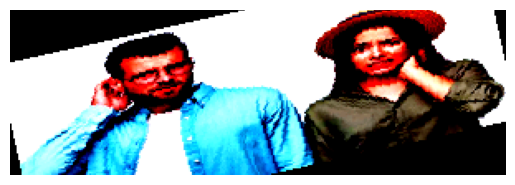

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.0474076].


label:  0


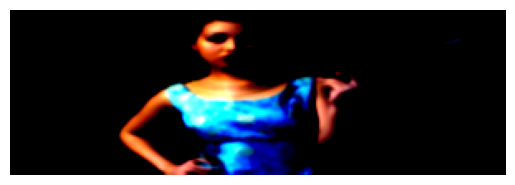

label:  0


In [13]:
# Show two normalized images
for batch in dataloader:
    if batch is None or len(batch) == 0:
        print("Empty batch detected, skipping...")
        continue

    imgs, labels = batch

    first_two_images = imgs[:2]  # Get first two images
    first_two_labels = labels[:2]
    print(first_two_images[0].shape)

    for img_tensor, label in zip(first_two_images, first_two_labels):
        plt.imshow(img_tensor.cpu().permute(1, 2, 0)) 
        plt.axis('off')  
        plt.show()
        print("label: ", label.item())
    break 

In [14]:
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn

In [15]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input dimension [3, 100, 300]

        self.model = models.resnet50(pretrained=False)

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]

            # nn.Conv2d(512, 1024, 3, 1, 1), # [1024, 4, 4]
            # nn.BatchNorm2d(1024),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2, 0),       # [1024, 2, 2]

            # nn.Conv2d(1024, 1024, 3, 1, 1), # [1024, 2, 2]
            # nn.BatchNorm2d(1024),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2, 0),       # [1024, 1, 1]
        )
        self.fc = nn.Sequential(
            # for resnet50
            nn.Linear(1000, 1024),
            nn.ReLU(),
            # for custom CNN
            # nn.Linear(512*4*4, 1024),
            # nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        # out = self.cnn(x)
        out = self.model(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [16]:
batch_size = 64
train_paths = train_df["file_name"].tolist()  
train_labels = train_df["label"].tolist()
val_paths = val_df["file_name"].tolist()  
val_labels = val_df["label"].tolist()
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = ImageDataset(train_paths, train_labels, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = ImageDataset(val_paths, val_labels, transform=transform)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [17]:
# "cuda" only when GPUs are available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
_exp_name = "Mar2"

# The number of training epochs and patience.
n_epochs = 100
patience = 300 # If no improvement in 'patience' epochs, early stop

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

/usr/local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 750/750 [10:03<00:00,  1.24it/s]


[ Train | 001/100 ] loss = 0.63019, acc = 0.71826


100%|██████████| 250/250 [03:11<00:00,  1.31it/s]


[ Valid | 001/100 ] loss = 0.64381, acc = 0.69094
[ Valid | 001/100 ] loss = 0.64381, acc = 0.69094 -> best
Best model found at epoch 0, saving model


100%|██████████| 750/750 [08:16<00:00,  1.51it/s]


[ Train | 002/100 ] loss = 0.42265, acc = 0.81120


100%|██████████| 250/250 [02:32<00:00,  1.64it/s]


[ Valid | 002/100 ] loss = 0.54486, acc = 0.70797
[ Valid | 002/100 ] loss = 0.54486, acc = 0.70797 -> best
Best model found at epoch 1, saving model


100%|██████████| 750/750 [07:36<00:00,  1.64it/s]


[ Train | 003/100 ] loss = 0.39572, acc = 0.83026


100%|██████████| 250/250 [02:18<00:00,  1.81it/s]


[ Valid | 003/100 ] loss = 0.36513, acc = 0.84070
[ Valid | 003/100 ] loss = 0.36513, acc = 0.84070 -> best
Best model found at epoch 2, saving model


100%|██████████| 750/750 [07:36<00:00,  1.64it/s]


[ Train | 004/100 ] loss = 0.38403, acc = 0.83389


100%|██████████| 250/250 [02:21<00:00,  1.76it/s]


[ Valid | 004/100 ] loss = 0.38037, acc = 0.83690
[ Valid | 004/100 ] loss = 0.38037, acc = 0.83690


100%|██████████| 750/750 [07:43<00:00,  1.62it/s]


[ Train | 005/100 ] loss = 0.37218, acc = 0.83709


100%|██████████| 250/250 [02:29<00:00,  1.67it/s]


[ Valid | 005/100 ] loss = 0.47973, acc = 0.77349
[ Valid | 005/100 ] loss = 0.47973, acc = 0.77349


100%|██████████| 750/750 [07:35<00:00,  1.65it/s]


[ Train | 006/100 ] loss = 0.36370, acc = 0.84364


100%|██████████| 250/250 [02:20<00:00,  1.78it/s]


[ Valid | 006/100 ] loss = 0.36550, acc = 0.83518
[ Valid | 006/100 ] loss = 0.36550, acc = 0.83518


100%|██████████| 750/750 [07:33<00:00,  1.65it/s]


[ Train | 007/100 ] loss = 0.35167, acc = 0.84991


100%|██████████| 250/250 [02:18<00:00,  1.80it/s]


[ Valid | 007/100 ] loss = 0.33327, acc = 0.86648
[ Valid | 007/100 ] loss = 0.33327, acc = 0.86648 -> best
Best model found at epoch 6, saving model


100%|██████████| 750/750 [07:40<00:00,  1.63it/s]


[ Train | 008/100 ] loss = 0.34217, acc = 0.85406


100%|██████████| 250/250 [02:27<00:00,  1.70it/s]


[ Valid | 008/100 ] loss = 0.44774, acc = 0.80181
[ Valid | 008/100 ] loss = 0.44774, acc = 0.80181


100%|██████████| 750/750 [07:29<00:00,  1.67it/s]


[ Train | 009/100 ] loss = 0.33740, acc = 0.85724


100%|██████████| 250/250 [02:16<00:00,  1.84it/s]


[ Valid | 009/100 ] loss = 0.35149, acc = 0.85081
[ Valid | 009/100 ] loss = 0.35149, acc = 0.85081


100%|██████████| 750/750 [07:30<00:00,  1.66it/s]


[ Train | 010/100 ] loss = 0.32804, acc = 0.86270


100%|██████████| 250/250 [02:18<00:00,  1.80it/s]


[ Valid | 010/100 ] loss = 0.33025, acc = 0.86379
[ Valid | 010/100 ] loss = 0.33025, acc = 0.86379


100%|██████████| 750/750 [07:32<00:00,  1.66it/s]


[ Train | 011/100 ] loss = 0.32424, acc = 0.86422


100%|██████████| 250/250 [02:17<00:00,  1.82it/s]


[ Valid | 011/100 ] loss = 0.41182, acc = 0.81727
[ Valid | 011/100 ] loss = 0.41182, acc = 0.81727


100%|██████████| 750/750 [07:26<00:00,  1.68it/s]


[ Train | 012/100 ] loss = 0.31537, acc = 0.86813


100%|██████████| 250/250 [02:17<00:00,  1.82it/s]


[ Valid | 012/100 ] loss = 0.64631, acc = 0.68364
[ Valid | 012/100 ] loss = 0.64631, acc = 0.68364


100%|██████████| 750/750 [07:21<00:00,  1.70it/s]


[ Train | 013/100 ] loss = 0.31467, acc = 0.86909


100%|██████████| 250/250 [02:19<00:00,  1.79it/s]


[ Valid | 013/100 ] loss = 0.33993, acc = 0.85531
[ Valid | 013/100 ] loss = 0.33993, acc = 0.85531


100%|██████████| 750/750 [07:24<00:00,  1.69it/s]


[ Train | 014/100 ] loss = 0.30231, acc = 0.87484


100%|██████████| 250/250 [02:17<00:00,  1.82it/s]


[ Valid | 014/100 ] loss = 0.29700, acc = 0.87900
[ Valid | 014/100 ] loss = 0.29700, acc = 0.87900 -> best
Best model found at epoch 13, saving model


100%|██████████| 750/750 [07:30<00:00,  1.66it/s]


[ Train | 015/100 ] loss = 0.30183, acc = 0.87545


100%|██████████| 250/250 [02:22<00:00,  1.75it/s]


[ Valid | 015/100 ] loss = 0.33196, acc = 0.86620
[ Valid | 015/100 ] loss = 0.33196, acc = 0.86620


100%|██████████| 750/750 [07:50<00:00,  1.59it/s]


[ Train | 016/100 ] loss = 0.29457, acc = 0.87844


100%|██████████| 250/250 [02:17<00:00,  1.82it/s]


[ Valid | 016/100 ] loss = 0.28924, acc = 0.88203
[ Valid | 016/100 ] loss = 0.28924, acc = 0.88203 -> best
Best model found at epoch 15, saving model


 19%|█▊        | 139/750 [01:24<06:14,  1.63it/s]